In [1]:
%matplotlib notebook
import numpy as np
from numpy.random import randn
import random
from six import string_types
from collections import OrderedDict

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.widgets import Slider, Button, RadioButtons
from matplotlib import animation

matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

from pd_rbase import *

import pandas as pd


import xarray as xr

from pandas.api import types as pd_types
from pandas.api.types import CategoricalDtype, union_categoricals
from pandas.plotting import scatter_matrix, andrews_curves, parallel_coordinates \
                           ,lag_plot, autocorrelation_plot, bootstrap_plot, radviz, table

import pandas.util.testing as tm
import pandas_datareader as pdweb
import pdvega

import qgrid

pd.core.common.is_list_like = pd.api.types.is_list_like
import colorcet as cc

np.random.seed(1)

pd.core.common.is_list_like = pd.api.types.is_list_like

import stemgraphic as stem

import os
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.formula.api as s_fm
from statsmodels.graphics.regressionplots import abline_plot

from scipy import stats, integrate, special
from scipy.stats.kde import gaussian_kde
from scipy.optimize import curve_fit
import scipy.stats as sci_st
import scipy.constants as phys

from dateutil.parser import parse
from datetime import datetime, date, time
from statutils import *
from sklearn.linear_model import LinearRegression as LR

import altair as alt
from altair import expr, datum
from boxplot import boxplot
#import starborn as star



# load a simple dataset as a pandas DataFrame
from vega_datasets import data as vegdat


def outers(group, colname=None, upper=None, lower=None):
    g  = group.name
    gval = group[colname]
    return group[(gval > upper.loc[g][colname]) | (gval < lower.loc[g][colname])][colname]

def outliers(g, colname=None):
    q1 = g.quantile(q=0.25)
    q3 = g.quantile(q=0.75)
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr
# prepare outlier data for plotting, we need coordinates for every outlier.
    out = g.apply(outers, colname=colname, upper=upper, lower=lower).dropna()
    cats = out.index.levels[0]
    
    outx = []
    outy = []
    if not out.empty:
        for cat in cats:
            if cat in out:
               for value in out[cat]:
                  outx.append(cat)
                  outy.append(value)
    return outx, outy

def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}
def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar):
            month_length[i] += 1
    return month_length

def sm_fit_line(x, y):
    """Return slope, intercept of best fit line."""
    model = sm.OLS(x, sm.add_constant(y), missing='drop') # ignores entires where x or y is NaN
    return model.fit().params


SCIPY_DISTRIBUTIONS = {
    'alpha': {'f':sci_st.alpha, 'params':{'a':3.57, 'loc':0.0, 'scale':1.0}}, 
    'anglit': {'f':sci_st.anglit, 'params':{'loc':0.0, 'scale':1.0}}, 
    'arcsine': {'f':sci_st.arcsine, 'params':{'loc':0.0, 'scale':1.0}}, 
    'beta': {'f':sci_st.beta, 'params':{'a':2.31, 'b':0.627, 'loc':0.0, 'scale':1.0}}, 
    'betaprime': {'f':sci_st.betaprime, 'params':{'a':5, 'b':6, 'loc':0.0, 'scale':1.0}}, 
    'bradford': {'f':sci_st.bradford, 'params':{'c':0.299, 'loc':0.0, 'scale':1.0}},
    'burr': {'f':sci_st.burr, 'params':{'c':10.5, 'd':4.3, 'loc':0.0, 'scale':1.0}}, 
    'cauchy': {'f':sci_st.cauchy, 'params':{'loc':0.0, 'scale':1.0}}, 
    'chi': {'f':sci_st.chi, 'params':{'df':78, 'loc':0.0, 'scale':1.0}}, 
    'chi2': {'f':sci_st.chi2, 'params':{'df':55, 'loc':0.0, 'scale':1.0}},
    'cosine': {'f':sci_st.cosine, 'params':{'loc':0.0, 'scale':1.0}}, 
    'dgamma': {'f':sci_st.dgamma, 'params':{'a':1.1, 'loc':0.0, 'scale':1.0}}, 
    'dweibull': {'f':sci_st.dweibull, 'params':{'c':2.07, 'loc':0.0, 'scale':1.0}}, 
    'erlang': {'f':sci_st.erlang, 'params':{'a':2, 'loc':0.0, 'scale':1.0}}, 
    'expon': {'f':sci_st.expon, 'params':{'loc':0.0, 'scale':1.0}}, 
    'exponnorm': {'f':sci_st.exponnorm, 'params':{'K':1.5, 'loc':0.0, 'scale':1.0}},
    'exponweib': {'f':sci_st.exponweib, 'params':{'a':2.89, 'c':1.95, 'loc':0.0, 'scale':1.0}}, 
    'exponpow': {'f':sci_st.exponpow, 'params':{'b':2.7, 'loc':0.0, 'scale':1.0}},
    'f': {'f':sci_st.f, 'params':{'dfn':29, 'dfd':18, 'loc':0.0, 'scale':1.0}}, 
    'fatigue': {'f':sci_st.fatiguelife, 'params':{'c':29, 'loc':0.0, 'scale':1.0}}, 
    'fisk': {'f':sci_st.fisk, 'params':{'c':3.09, 'loc':0.0, 'scale':1.0}}, 
    'foldcauchy': {'f':sci_st.foldcauchy, 'params':{'c':4.72, 'loc':0.0, 'scale':1.0}},
    'foldnorm': {'f':sci_st.foldnorm, 'params':{'c':1.95, 'loc':0.0, 'scale':1.0}}, 
    'genlogistic': {'f':sci_st.genlogistic, 'params':{'c':0.412, 'loc':0.0, 'scale':1.0}},
    'genpareto': {'f':sci_st.genpareto, 'params':{'c':0.1, 'loc':0.0, 'scale':1.0}}, 
    'gennorm': {'f':sci_st.gennorm, 'params':{'beta':1.3, 'loc':0.0, 'scale':1.0}}, 
    'genexpon': {'f':sci_st.genexpon, 'params':{'a':9.13, 'b':16.2, 'c':3.28, 'loc':0.0, 'scale':1.0}}, 
    'genextreme': {'f':sci_st.genextreme, 'params':{'c':-0.1, 'loc':0.0, 'scale':1.0}},
    'gausshyper': {'f':sci_st.gausshyper, 'params':{'a':13.8, 'b':3.12, 'c':2.51, 'z':5.18, 'loc':0.0, 'scale':1.0}}, 
    'gamma': {'f':sci_st.gamma, 'params':{'a':1.99, 'loc':0.0, 'scale':1.0}},
    'gengamma': {'f':sci_st.gengamma, 'params':{'a':4.42, 'c':-3.12, 'loc':0.0, 'scale':1.0}}, 
    'genhalflogistic': {'f':sci_st.genhalflogistic, 'params':{'c':0.773, 'loc':0.0, 'scale':1.0}},
    'gilbrat': {'f':sci_st.gilbrat, 'params':{'loc':0.0, 'scale':1.0}}, 
    'gompertz': {'f':sci_st.gompertz, 'params':{'c':0.947, 'loc':0.0, 'scale':1.0}},
    'gumbel_r': {'f':sci_st.gumbel_r, 'params':{'loc':0.0, 'scale':1.0}}, 
    'gumbel_l': {'f':sci_st.gumbel_l, 'params':{'loc':0.0, 'scale':1.0}},
    'halfcauchy': {'f':sci_st.halfcauchy, 'params':{'loc':0.0, 'scale':1.0}}, 
    'halflogistic': {'f':sci_st.halflogistic, 'params':{'loc':0.0, 'scale':1.0}},
    'halfnorm': {'f':sci_st.halfnorm, 'params':{'loc':0.0, 'scale':1.0}}, 
    'halfgennorm': {'f':sci_st.halfgennorm, 'params':{'beta':0.675, 'loc':0.0, 'scale':1.0}},
    'hypsecant': {'f':sci_st.hypsecant, 'params':{'loc':0.0, 'scale':1.0}}, 
    'invgamma': {'f':sci_st.invgamma, 'params':{'a':4.07, 'loc':0.0, 'scale':1.0}},
    'invgauss': {'f':sci_st.invgauss, 'params':{'mu':0.145, 'loc':0.0, 'scale':1.0}}, 
    'invweibull': {'f':sci_st.invweibull, 'params':{'c':10.6, 'loc':0.0, 'scale':1.0}},
    'johnsonsb': {'f':sci_st.johnsonsb, 'params':{'a':4.32, 'b':3.18, 'loc':0.0, 'scale':1.0}}, 
    'johnsonsu': {'f':sci_st.johnsonsu, 'params':{'a':2.55, 'b':2.25, 'loc':0.0, 'scale':1.0}},
    'ksone': {'f':sci_st.ksone, 'params':{'n':1e+03, 'loc':0.0, 'scale':1.0}}, 
    'kstwobign': {'f':sci_st.kstwobign, 'params':{'loc':0.0, 'scale':1.0}},
    'laplace': {'f':sci_st.laplace, 'params':{'loc':0.0, 'scale':1.0}}, 
    'levy': {'f':sci_st.levy, 'params':{'loc':0.0, 'scale':1.0}},
    'levy_l': {'f':sci_st.levy_l, 'params':{'loc':0.0, 'scale':1.0}}, 
    'levy_stable': {'f':sci_st.levy_stable, 'params':{'alpha':0.357, 'beta':-0.675, 'loc':0.0, 'scale':1.0}},
    'logistic': {'f':sci_st.logistic, 'params':{'loc':0.0, 'scale':1.0}}, 
    'loggamma': {'f':sci_st.loggamma, 'params':{'c':0.414, 'loc':0.0, 'scale':1.0}},
    'loglaplace': {'f':sci_st.loglaplace, 'params':{'c':3.25, 'loc':0.0, 'scale':1.0}}, 
    'lognorm': {'f':sci_st.lognorm, 'params':{'s':0.954, 'loc':0.0, 'scale':1.0}},
    'lomax': {'f':sci_st.lomax, 'params':{'c':1.88, 'loc':0.0, 'scale':1.0}}, 
    'maxwell': {'f':sci_st.maxwell, 'params':{'loc':0.0, 'scale':1.0}},
    'mielke': {'f':sci_st.mielke, 'params':{'k':10.4, 's':3.6, 'loc':0.0, 'scale':1.0}}, 
    'nakagami': {'f':sci_st.nakagami, 'params':{'nu':4.97, 'loc':0.0, 'scale':1.0}},
    'ncx2': {'f':sci_st.ncx2, 'params':{'df':21, 'nc':1.06, 'loc':0.0, 'scale':1.0}}, 
    'ncf': {'f':sci_st.ncf, 'params':{'dfn':27, 'dfd':27, 'nc':0.416, 'loc':0.0, 'scale':1.0}},
    'nct': {'f':sci_st.nct, 'params':{'df':14, 'nc':0.24, 'loc':0.0, 'scale':1.0}}, 
    'norm': {'f':sci_st.norm, 'params':{'loc':0.0, 'scale':1.0}},
    'pareto': {'f':sci_st.pareto, 'params':{'b':2.62, 'loc':0.0, 'scale':1.0}}, 
    'pearson3': {'f':sci_st.pearson3, 'params':{'skew':0.1, 'loc':0.0, 'scale':1.0}},
    'powerlaw': {'f':sci_st.powerlaw, 'params':{'a':1.66, 'loc':0.0, 'scale':1.0}}, 
    'powerlognorm': {'f':sci_st.powerlognorm, 'params':{'c':2.14, 's':0.446, 'loc':0.0, 'scale':1.0}},
    'powernorm': {'f':sci_st.powernorm, 'params':{'c':4.45, 'loc':0.0, 'scale':1.0}}, 
    'rdist': {'f':sci_st.rdist, 'params':{'c':0.9, 'loc':0.0, 'scale':1.0}},
    'reciprocal': {'f':sci_st.reciprocal, 'params':{'a':0.00623, 'b':1.01, 'loc':0.0, 'scale':1.0}}, 
    'rayleigh': {'f':sci_st.rayleigh, 'params':{'loc':0.0, 'scale':1.0}},
    'rice': {'f':sci_st.rice, 'params':{'b':0.775, 'loc':0.0, 'scale':1.0}}, 
    'recipinvgauss': {'f':sci_st.recipinvgauss, 'params':{'mu':0.63, 'loc':0.0, 'scale':1.0}},
    'semicircular': {'f':sci_st.semicircular, 'params':{'loc':0.0, 'scale':1.0}}, 
    't': {'f':sci_st.t, 'params':{'df':2.74, 'loc':0.0, 'scale':1.0}},
    'triang': {'f':sci_st.triang, 'params':{'c':0.158, 'loc':0.0, 'scale':1.0}}, 
    'truncexpon': {'f':sci_st.truncexpon, 'params':{'b':4.69, 'loc':0.0, 'scale':1.0}},
    'truncnorm': {'f':sci_st.truncnorm, 'params':{'a':0.1, 'b':2, 'loc':0.0, 'scale':1.0}}, 
    'tukeylambda': {'f':sci_st.tukeylambda, 'params':{'lam':3.13, 'loc':0.0, 'scale':1.0}},
    'uniform': {'f':sci_st.uniform, 'params':{'loc':0.0, 'scale':1.0}}, 
    'vonmises': {'f':sci_st.vonmises, 'params':{'kappa':3.99, 'loc':0.0, 'scale':1.0}},
    'vonmises_line': {'f':sci_st.vonmises_line, 'params':{'kappa':3.99, 'loc':0.0, 'scale':1.0}}, 
    'wald': {'f':sci_st.wald, 'params':{'loc':0.0, 'scale':1.0}},
    'weibull_min': {'f':sci_st.weibull_min, 'params':{'c':1.79, 'loc':0.0, 'scale':1.0}}, 
    'weibull_max': {'f':sci_st.weibull_max, 'params':{'c':2.87, 'loc':0.0, 'scale':1.0}},
    'wrapcauchy': {'f':sci_st.wrapcauchy, 'params':{'c':0.0311, 'loc':0.0, 'scale':1.0}}
}


def plot_distribution(dt, dist, params, bins=40):

   y, x = np.histogram(dt, bins=bins, density=True)
   width = 0.7 * (x[1] - x[0])
   x = (x + np.roll(x, -1))[:-1] / 2.0
   hist = pd.DataFrame({'x':x,'y':y})

   dist = dist

   pdf_y = dist.pdf(x, **params)
   pdf = pd.DataFrame({'y':pdf_y,'x': x})

   return hist, pdf, width


alt.renderers.enable('default')

#ALTAIR DEFAULT VIEW

def default_view():
    return {
        'config': {
            'view': {
                'height': 400,
                'width': 600,
            }
        }
    }

def boxplot_altair(data, x, y, xtype='N', ytype='Q',
                   size=40, width=400, yscale=None):
    """
    Python function to make boxplots in Altair
    """
    # Define variables and their types using f-strings in Python
    lower_box=f'q1({y}):{ytype}'
    lower_whisker=f'min({y}):{ytype}'
    upper_box=f'q3({y}):{ytype}'
    upper_whisker=f'max({y}):{ytype}'
    median_whisker=f'median({y}):{ytype}'
    x_data=f'{x}:{xtype}'
 
    # lower plot
    if yscale is not None:
        lower_plot = alt.Chart(data).mark_rule().encode(
            y=alt.Y(lower_whisker, axis=alt.Axis(title=y), scale=yscale),
            y2=lower_box,
            x=x_data
    ).properties(
        width=width)
    else:
        lower_plot = alt.Chart(data).mark_rule().encode(
            y=alt.Y(lower_whisker, axis=alt.Axis(title=y)),
            y2=lower_box,
            x=x_data
    ).properties(
        width=width)
 
    # middle plot
    middle_plot = alt.Chart(data).mark_bar(size=size).encode(
        y=lower_box,
        y2=upper_box,
        x=x_data
    ).properties(
        width=width)
 
    # upper plot
    upper_plot = alt.Chart(data).mark_rule().encode(
        y=upper_whisker,
        y2=upper_box,
        x=x_data
    ).properties(
        width=width)
     
    # median marker line
    middle_tick = alt.Chart(data).mark_tick(
        color='white',
        size=size
    ).encode(
        y=median_whisker,
        x=x_data,
    )
     
    # combine all the elements of boxplot to a single chart object
    chart = lower_plot + middle_plot + upper_plot + middle_tick
     
    # return chart object
    return chart



def rename_dots(cols, prefix=''):
    _cols  = cols.copy()
    if prefix != '':
        _cols = [item.replace(prefix,'') for item in _cols]
    _cols = [item.replace('.','_') for item in _cols]
    return dict(zip(cols,_cols))





from describe import DFSummary

# register the custom theme under a chosen name
alt.themes.register('default_view', default_view)

# enable the newly registered theme
alt.themes.enable('default_view')

alt.data_transformers.enable('json')

print("numpy version  : ", np.__version__)
print("pandas version : ", pd.__version__)
print("xarray version : ", xr.__version__)
print("altair version : ", alt.__version__)
print("qgrid version : ", qgrid.__version__)
print("rpy2 version: ", rpy2.__version__)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


numpy version  :  1.17.0
pandas version :  1.0.3
xarray version :  0.15.1
altair version :  4.1.0
qgrid version :  1.3.1
rpy2 version:  3.3.2


In [56]:


def mp_subplot_hist(ax, data, bins=30, width=0.7, ticksize=10, title=''
                    ,xlabel='', ylabel=''):
   hist, bins = np.histogram(data, bins=30)
   width = width * (bins[1] - bins[0])
   center = (bins[:-1] + bins[1:]) / 2
   ax.bar(center, hist, align='center', width=width)
   ax.set_title(title, size=12)
   ax.set_xlabel(xlabel, size=10)
   ax.set_ylabel(ylabel, size=10)
   ax.tick_params('x')

   return ax


In [2]:
iris = pd.read_csv('../vega_data/iris.csv')
iris.head()



,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
alt.Chart(iris).mark_circle(size=80).encode(
    alt.X('sepal_width',
        scale=alt.Scale(zero=False)
    ),
    alt.Y('sepal_length',
        scale=alt.Scale(zero=False)
    ),
    color=alt.Color('species')
)

alt.Chart(...)

In [5]:
alt.Chart(iris).mark_point(size=70, filled=True).encode(
    alt.X('sepal_width',
        scale=alt.Scale(zero=False)
    ),
    alt.Y('sepal_length',
        scale=alt.Scale(zero=False)
    ),
    color=alt.Color('species'),
    shape='species'
)

alt.Chart(...)

In [6]:
R.library('lattice')

R.dset_list()
#print(R.packdesc('lattice'))
singers =  R.data_from('lattice','singer')
#singers.head()

df_singers = R.R2pd(singers)
df_singers = df_singers.rename(columns={'singer.voice.part':'voice_part'
                                        ,'singer.height':'height'})
#df_singers.head()

#QGRID
qgrid_w = qgrid.show_grid(df_singers, show_toolbar=True)
qgrid_w


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [7]:
alt.Chart(df_singers).mark_circle(size=60).encode(
    
    alt.Y('height',
        scale=alt.Scale(zero=False)
    ),
    x='voice_part'
)

alt.Chart(...)

In [8]:
points = alt.Chart(df_singers, width=400).mark_point(filled=True).encode(
    alt.Y(
        'mean(height)',
        scale=alt.Scale(zero=False),
        axis=alt.Axis(title='Singers Height')
    ),
    x='voice_part',
    color=alt.value('black')
)

error_bars = alt.Chart(df_singers).mark_rule().encode(
    y='ci0(height)',
    y2='ci1(height)',
    x='voice_part'
)

points + error_bars

alt.LayerChart(...)

<IPython.core.display.Javascript object>


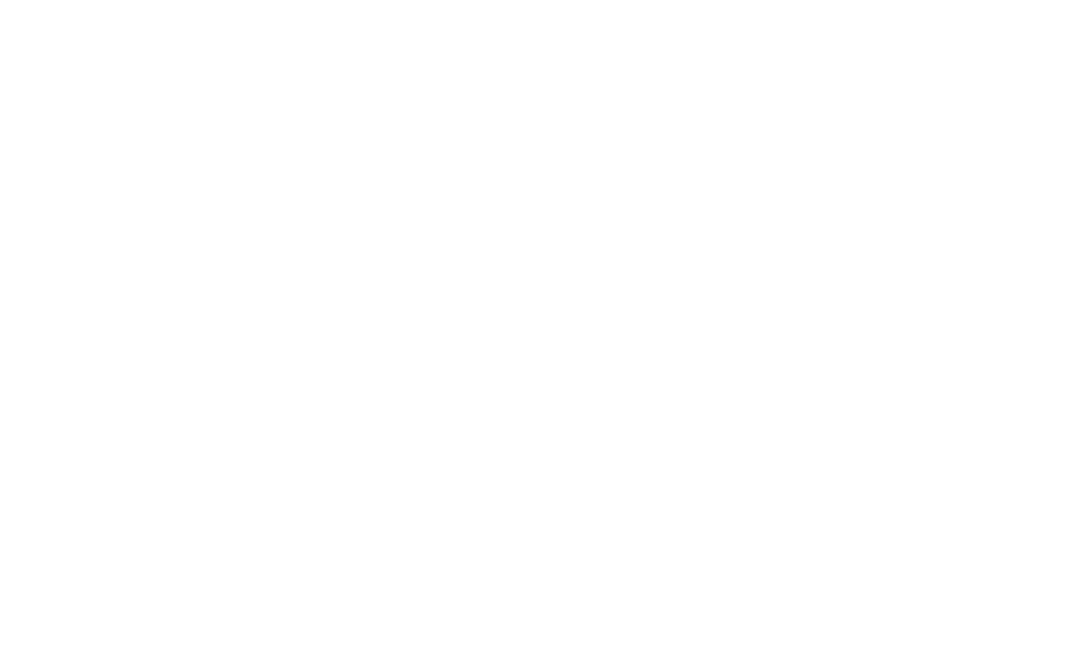

<IPython.core.display.Javascript object>


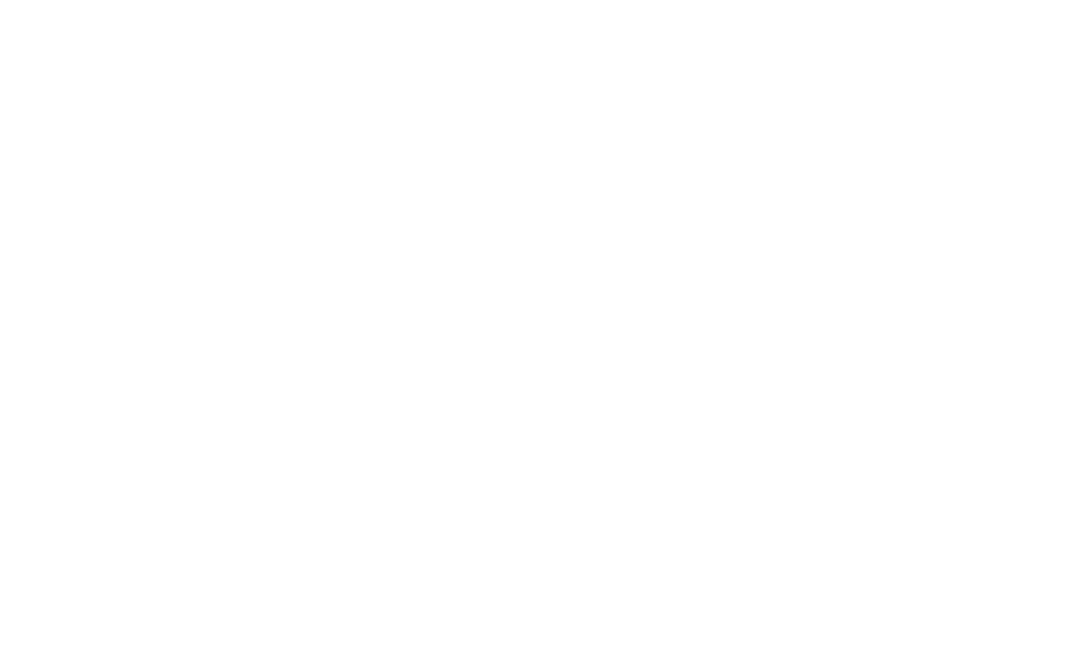

In [9]:
x = np.arange(0.1, 4, 0.5)
y = np.exp(-x)

# example variable error bar values
yerr = 0.1 + 0.2*np.sqrt(x)
xerr = 0.1 + yerr

# First illustrate basic pyplot interface, using defaults where possible.
plt.figure(figsize=(8,5))
plt.errorbar(x, y, xerr=0.2, yerr=0.4)
plt.title("Simplest errorbars, 0.2 in x, 0.4 in y")

# Now switch to a more OO interface to exercise more features.
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(8,5))
ax = axs[0,0]
ax.errorbar(x, y, yerr=yerr, fmt='o')
ax.set_title('Vert. symmetric')

# With 4 subplots, reduce the number of axis ticks to avoid crowding.
ax.locator_params(nbins=4)

ax = axs[0,1]
ax.errorbar(x, y, xerr=xerr, fmt='o')
ax.set_title('Hor. symmetric')

ax = axs[1,0]
ax.errorbar(x, y, yerr=[yerr, 2*yerr], xerr=[xerr, 2*xerr], fmt='--o')
ax.set_title('H, V asymmetric')

ax = axs[1,1]
ax.set_yscale('log')
# Here we have to be careful to keep all y values positive:
ylower = np.maximum(1e-2, y - yerr)
yerr_lower = y - ylower

ax.errorbar(x, y, yerr=[yerr_lower, 2*yerr], xerr=xerr,
            fmt='o', ecolor='g', capthick=2)
ax.set_title('Mixed sym., log y')

fig.suptitle('Variable errorbars')

plt.show()

<IPython.core.display.Javascript object>


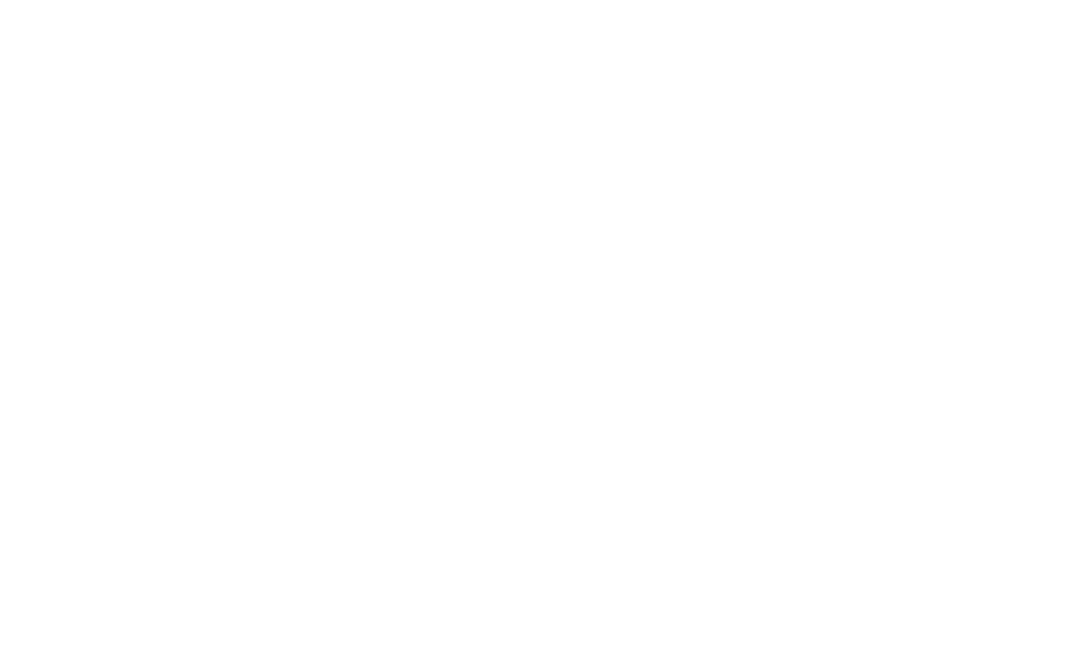

In [10]:


df_singers.boxplot(by='voice_part', figsize=(8,5))


In [11]:
population = vegdat.population.url
#boxplot_altair(population, 'age', 'people', size=10, width=400)
alt.Chart(population).mark_boxplot(extent='min-max').encode(
    x='age:O',
    y='people:Q'
)

alt.Chart(...)

In [12]:

R.library('gapminder')
#print(R.packdesc('gapminder'))
gapm =   R.rdata('gapminder')
gapm.head()


,country,continent,year,lifeExp,pop,gdpPercap
1,Afghanistan,Asia,1952,28.801,8425333,779.445314
2,Afghanistan,Asia,1957,30.332,9240934,820.853030
3,Afghanistan,Asia,1962,31.997,10267083,853.100710
4,Afghanistan,Asia,1967,34.020,11537966,836.197138
5,Afghanistan,Asia,1972,36.088,13079460,739.981106


In [13]:
boxplot_altair(gapm, 'continent', 'lifeExp', width=400)

alt.LayerChart(...)

In [14]:
boxplot_altair(df_singers, 'voice_part', 'height', width=400, yscale=alt.Scale(domain=[58, 78]))


alt.LayerChart(...)

In [15]:
fful = pd.read_csv('../data/datasets/faithful.csv')
fful.head()

,Unnamed: 0,eruptions,waiting
0,1,3.600,79
1,2,1.800,54
2,3,3.333,74
3,4,2.283,62
4,5,4.533,85


In [16]:

bar = alt.Chart(fful).mark_bar().encode(
    alt.X('eruptions:Q', bin=alt.Bin(maxbins=18), axis=None),
    alt.Y('count()')
)

rule = alt.Chart(fful).mark_rule(color='red').encode(
    x='mean(eruptions):Q',
    size=alt.value(5)
)

bar + rule

alt.LayerChart(...)

In [17]:
iris = vegdat.iris()

alt.Chart(iris).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='species:N'
).properties(
    width=150,
    height=200
).repeat(
    row=['petalLength', 'petalWidth','sepalLength', 'sepalWidth', ],
    column=['sepalLength', 'sepalWidth', 'petalLength', 'petalWidth']
).interactive()

alt.RepeatChart(...)

In [18]:
source = vegdat.population.url

alt.Chart(source).mark_bar(stroke='transparent').encode(
    alt.X('gender:N', axis=alt.Axis(title='')),
    alt.Y('sum(people):Q', axis=alt.Axis(title='population', grid=False)),
    color=alt.Color('gender:N', scale=alt.Scale(range=["#EA98D2", "#659CCA"])),
    column='age:O'
).properties(width={"step": 10}
).configure_view(
    stroke='transparent'
).configure_axis(
    domainWidth=0.8
).transform_filter(
    datum.year == 2000
).transform_calculate(
    'gender', expr.if_(datum.sex == 2, 'Female', 'Male')
)


alt.Chart(...)

In [19]:
iris = vegdat.iris()


alt.Chart(iris).mark_point().encode(
    x='petalLength:Q',
    y='petalWidth:Q',
    color='species:N',
    facet='petalWidth:Q'
).properties(
    width=80,
    height=80
)



alt.Chart(...)

In [20]:
#trellis
source = iris
alt.Chart(source).mark_point(filled=True).encode(
    x='petalLength:Q',
    y='petalWidth:Q',
    column='species:N',
).properties(
    width=200
)

alt.Chart(...)

In [21]:
alt.Chart(vegdat.cars.url).mark_circle().encode(
    alt.X(alt.repeat("column"), type='quantitative'),
    alt.Y(alt.repeat("row"), type='quantitative'),
    color='Origin:N'
).properties(
    width=250,
    height=250
).repeat(
    row=['Horsepower', 'Acceleration', 'Miles_per_Gallon'],
    column=['Miles_per_Gallon', 'Acceleration', 'Horsepower']
).interactive()


alt.RepeatChart(...)

In [22]:
d_env = pd.read_csv('../data/DoubsEnv.csv')

d_spa = pd.read_csv('../data/DoubsSpa.csv')
d_spa.head(5)
d_env.head(5)
d_spe = pd.read_csv('../data/DoubsSpe.csv')
d_spe.columns.values
d_spe.head()
d_spa['sizes'] = d_spe.BAR + 1 * 4

d_spa['line_order'] = np.array(d_spa.index)
d_spa.head()


,X,Y,sizes,line_order
0,85.678,20.000,4,0
1,84.955,20.100,4,1
2,92.301,23.796,4,2
3,91.280,26.431,4,3
4,92.005,29.163,4,4


In [23]:

base = alt.Chart(d_spa).encode(
    x='X',
    y='Y',
    order='line_order'
)
c = alt.Chart(d_spa).mark_circle().encode(
    alt.X('X:Q'),
    alt.Y('Y:Q'),
    size='sizes'
)
c + base.mark_trail() 

alt.LayerChart(...)

In [24]:

d_tru = pd.DataFrame({'X': d_spa['X'],'Y': d_spa['Y'],'count': d_spe['TRU']*5,
                      'Species':'TRU', 'line_order':np.array(d_spa.index)})
d_omb = pd.DataFrame({'X': d_spa['X'],'Y': d_spa['Y'],'count': d_spe['OMB']*5,
                      'Species':'OMB','line_order':np.array(d_spa.index)})
d_hot = pd.DataFrame({'X': d_spa['X'],'Y': d_spa['Y'],'count': d_spe['HOT']*5,
                      'Species':'HOT', 'line_order':np.array(d_spa.index)})

b_tru = alt.Chart(d_tru).encode(
    x='X',
    y='Y',
    order='line_order'
).properties(
    width=300,
    height=250
)
t1 = alt.Chart(d_tru).mark_circle().encode(
    alt.X('X:Q'),
    alt.Y('Y:Q'),
    size='count'
)
f1 = b_tru.mark_trail() + t1

b_omb = alt.Chart(d_omb).encode(
    x='X',
    y='Y',
    order='line_order'
).properties(
    width=300,
    height=250
)
t2 = alt.Chart(d_omb).mark_circle().encode(
    alt.X('X:Q'),
    alt.Y('Y:Q'),
    size='count'
)
f2 = b_omb.mark_trail() + t2

b_hot = alt.Chart(d_hot).encode(
    x='X',
    y='Y',
    order='line_order'
).properties(
    width=300,
    height=250
)
t3 = alt.Chart(d_hot).mark_circle().encode(
    alt.X('X:Q'),
    alt.Y('Y:Q'),
    size='count'
)
f3 = b_hot.mark_trail() + t3

f1|f2&f3

alt.HConcatChart(...)

In [25]:
pop = vegdat.population()
pop
pink_blue = alt.Scale(domain=('Male', 'Female'),
                      range=["steelblue", "salmon"])

slider = alt.binding_range(min=1900, max=2000, step=10)
select_year = alt.selection_single(name="year", fields=['year'], bind=slider)

alt.Chart(pop).mark_bar().encode(
    x=alt.X('sex:N', axis=alt.Axis(title=None)),
    y=alt.Y('people:Q', scale=alt.Scale(domain=(0, 12000000))),
    color=alt.Color('sex:N', scale=pink_blue),
    column='age:O'
).properties(
    width=20
).add_selection(
    select_year
).transform_calculate(
    "sex", expr.if_(datum.sex == 1, "Male", "Female")
).transform_filter(
    select_year
)

alt.Chart(...)

In [26]:
cars = vegdat.cars.url

brush = alt.selection(type='interval')

points = alt.Chart().mark_point(size=70, filled=True).encode(
    x='Horsepower:Q',
    y='Miles_per_Gallon:Q',
    color=alt.condition(brush, 'Origin:N', alt.value('lightgray'))
).add_selection(
    brush
)

bars = alt.Chart().mark_bar().encode(
    y='Origin:N',
    color='Origin:N',
    x='count(Origin):Q'
).transform_filter(
    brush
)

alt.vconcat(points, bars, data=cars)


alt.VConcatChart(...)

<IPython.core.display.Javascript object>


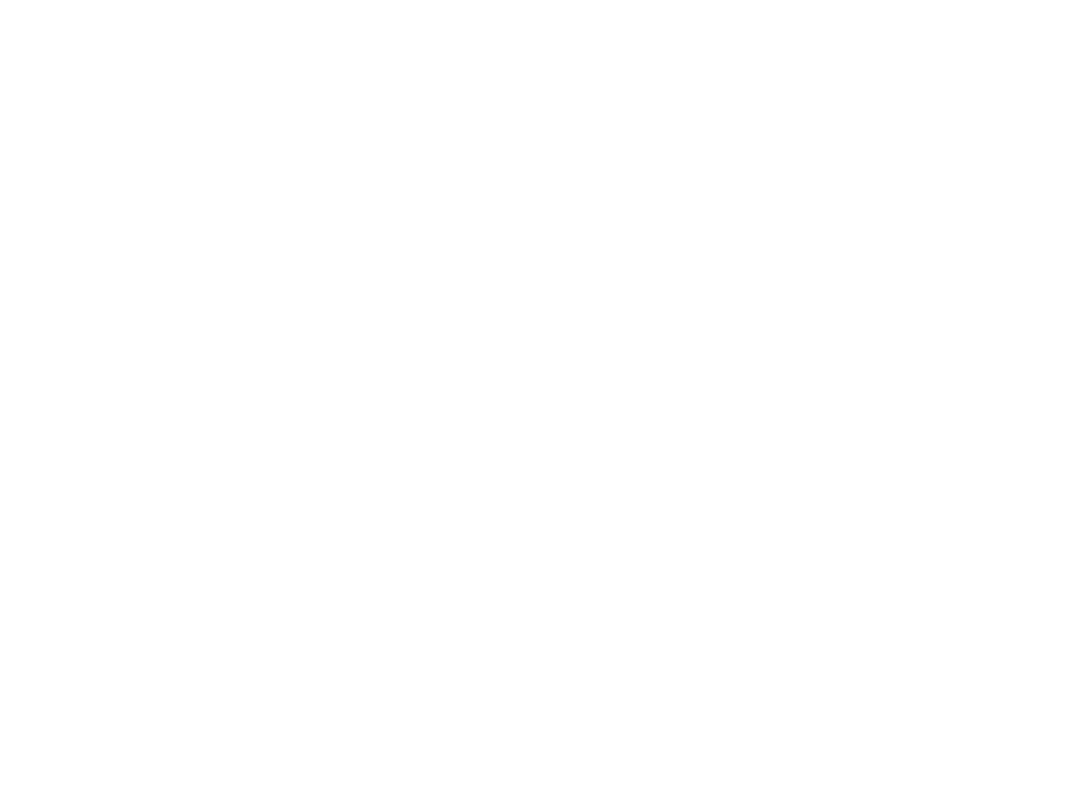

In [27]:



fig, ax = plt.subplots(figsize=(8,6))
plt.subplots_adjust(left=0.25, bottom=0.25)
t = np.arange(0.0, 1.0, 0.001)
a0 = 5
f0 = 3
delta_f = 5.0
s = a0*np.sin(2*np.pi*f0*t)
l, = plt.plot(t, s, lw=2, color='red')
plt.axis([0, 1, -10, 10])

axcolor = 'lightgoldenrodyellow'
axfreq = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
axamp = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)

sfreq = Slider(axfreq, 'Freq', 0.1, 30.0, valinit=f0, valstep=delta_f)
samp = Slider(axamp, 'Amp', 0.1, 10.0, valinit=a0)


def update(val):
    amp = samp.val
    freq = sfreq.val
    l.set_ydata(amp*np.sin(2*np.pi*freq*t))
    fig.canvas.draw_idle()
sfreq.on_changed(update)
samp.on_changed(update)

resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    sfreq.reset()
    samp.reset()
button.on_clicked(reset)

rax = plt.axes([0.025, 0.5, 0.15, 0.15], facecolor=axcolor)
radio = RadioButtons(rax, ('red', 'blue', 'green'), active=0)


def colorfunc(label):
    l.set_color(label)
    fig.canvas.draw_idle()
radio.on_clicked(colorfunc)

plt.show()

In [28]:
fbk = pd.read_csv('../Ott/FacebookNarcissism.csv')
fbk.head()

,id,NPQC_R_Total,Rating_Type,Rating
0,1,31.0,Attractive,2
1,1,31.0,Fashionable,2
2,1,31.0,Glamourous,2
3,1,31.0,Cool,2
4,2,37.0,Attractive,2


In [29]:
alt.Chart(fbk).mark_point(filled=True).encode(
    alt.X('NPQC_R_Total',
        scale=alt.Scale(zero=False)
    ),
    alt.Y('Rating',
        scale=alt.Scale(zero=False)
    ),
    color=alt.value('red')
)

alt.Chart(...)

In [30]:
exax = pd.read_csv('../Ott/Exam Anxiety.csv')
exax.head()

,Code,Revise,Exam,Anxiety,Gender
0,1,4,40,86.298,Male
1,2,11,65,88.716,Female
2,3,27,80,70.178,Male
3,4,53,80,61.312,Male
4,5,4,40,89.522,Male


In [31]:
ex = alt.Chart(exax).mark_point(filled=True).encode(
    alt.X('Exam'
    ),
    alt.Y('Anxiety'
    ),
    color=alt.Color('Gender'),
    shape='Gender'
)
z = np.polyfit(x=exax.loc[:, 'Anxiety'], y=exax.loc[:, 'Exam'], deg=4)
polynomial = np.poly1d(z)
x = np.linspace(exax.loc[:, 'Anxiety'].min(), exax.loc[:, 'Anxiety'].max(), 100)
y = polynomial(x)

ex_regr= pd.DataFrame({'x':x, 'y':y})

regr = alt.Chart(ex_regr).mark_line().encode(
    alt.X('x'
    ),
    alt.Y('y'
    ),
    color=alt.value('red')
)

ex+regr

alt.LayerChart(...)

In [32]:
fest = pd.read_csv('../Ott/DownloadFestival.csv')
fest0 = fest[fest['day1'] < 20]
fest0.head()

,ticknumb,gender,day1,day2,day3
0,2111,Male,2.64,1.35,1.61
1,2229,Female,0.97,1.41,.29
2,2338,Male,0.84,,
3,2384,Female,3.03,,
4,2401,Female,0.88,.08,


In [33]:
bar = alt.Chart(fest).mark_bar().encode(
    alt.X('day1', bin=alt.BinParams(maxbins=80)),
    alt.Y('count()')
)
bar

alt.Chart(...)

In [34]:
g = df_singers.groupby('voice_part')

outx, outy= outliers(g, colname='height')

outl = pd.DataFrame({'voice_part': outx, 'height':outy})

boxp = boxplot_altair(df_singers, 'voice_part', 'height', width=400, yscale=alt.Scale(domain=[58, 78]))
outp = alt.Chart(outl).mark_point(filled=True, size=70).encode(
    alt.X('voice_part:N'),
    alt.Y('height:Q'),
    alt.Color(value='black')
)
boxp + outp


alt.LayerChart(...)

In [35]:
f = fest[['gender','day1']]
g = f.groupby('gender')


outx, outy= outliers(g, colname='day1')

outl = pd.DataFrame({'gender': outx, 'day1':outy})

boxp = boxplot_altair(fest, 'gender', 'day1', width=400, yscale=alt.Scale(domain=[0, 21]))
outp = alt.Chart(outl).mark_point(filled=True, size=70).encode(
    alt.X('gender:N'),
    alt.Y('day1:Q'),
    alt.Color(value='black')
)
boxp + outp


alt.LayerChart(...)

In [36]:
bar = alt.Chart(fest0).mark_bar().encode(
    alt.X('day1', bin=alt.BinParams(maxbins=40), scale=alt.Scale(domain=[0,4.0])),
    alt.Y('count()')
)
bar


alt.Chart(...)

In [37]:
dt = fest0['day1']
dt.head()

dist = SCIPY_DISTRIBUTIONS['norm']['f']
params = dist.fit(dt)

arg = params[:-2]
loc = params[-2]
scale = params[-1]

params = {'loc':loc, 'scale':scale}
hist, pdf, width = plot_distribution(dt, dist, params, bins=40)

bar = alt.Chart(hist).mark_bar().encode(
    alt.X('x:Q', bin=alt.BinParams(maxbins=40)),
    alt.Y('y:Q')
)
dist = alt.Chart(pdf).mark_line(color='black').encode(
    alt.X('x:Q'),
    alt.Y('y:Q')
)
alt.layer(
    bar,
    dist
).resolve_scale(
    x='independent'
)


alt.LayerChart(...)

In [38]:
rexam = pd.read_csv('../Ott/RExam.csv')
rexam.head()

,exam,computer,lectures,numeracy,uni
0,18,54,75.0,7,0
1,30,47,8.5,1,0
2,40,58,69.5,6,0
3,30,37,67.0,6,0
4,40,53,44.5,2,0


In [39]:
rexam['uni']= rexam['uni'].astype('category')
rexam['uni'] = rexam.uni.cat.rename_categories({0:'Duncetown',1:'Sussex'})

rexam.head()

,exam,computer,lectures,numeracy,uni
0,18,54,75.0,7,Duncetown
1,30,47,8.5,1,Duncetown
2,40,58,69.5,6,Duncetown
3,30,37,67.0,6,Duncetown
4,40,53,44.5,2,Duncetown


In [40]:

dt = rexam['exam']
DIST = SCIPY_DISTRIBUTIONS['norm']['f']
params = DIST.fit(dt)

arg = params[:-2]
loc = params[-2]
scale = params[-1]

params = {'loc':loc, 'scale':scale}
hist, pdf, width = plot_distribution(dt, DIST, params, bins=40)

bar = alt.Chart(hist).mark_bar().encode(
    alt.X('x:Q', bin=alt.BinParams(maxbins=50)),
    alt.Y('y:Q')
).properties(title='Exam', width=400)
dist = alt.Chart(pdf).mark_line(color='black').encode(
    alt.X('x:Q'),
    alt.Y('y:Q')
)
f1 = bar+dist

dt = rexam['lectures']
params = DIST.fit(dt)

arg = params[:-2]
loc = params[-2]
scale = params[-1]

params = {'loc':loc, 'scale':scale}
hist, pdf, width = plot_distribution(dt, DIST, params, bins=40)

bar = alt.Chart(hist).mark_bar().encode(
    alt.X('x:Q', bin=alt.BinParams(maxbins=50)),
    alt.Y('y:Q')
).properties(title='Lectures', width=400)
dist = alt.Chart(pdf).mark_line(color='black').encode(
    alt.X('x:Q'),
    alt.Y('y:Q')
)
f2 = bar+dist

dt = rexam['computer']
params = DIST.fit(dt)

arg = params[:-2]
loc = params[-2]
scale = params[-1]

params = {'loc':loc, 'scale':scale}
hist, pdf, width = plot_distribution(dt, DIST, params, bins=40)

bar = alt.Chart(hist).mark_bar().encode(
    alt.X('x:Q', bin=alt.BinParams(maxbins=50)),
    alt.Y('y:Q')
).properties(title='Computer', width=400)
dist = alt.Chart(pdf).mark_line(color='black').encode(
    alt.X('x:Q'),
    alt.Y('y:Q')
)
f3 = bar+dist

dt = rexam['numeracy']
params = DIST.fit(dt)

arg = params[:-2]
loc = params[-2]
scale = params[-1]

params = {'loc':loc, 'scale':scale}
hist, pdf, width = plot_distribution(dt, DIST, params, bins=40)

bar = alt.Chart(hist).mark_bar().encode(
    alt.X('x:Q', bin=alt.BinParams(maxbins=50)),
    alt.Y('y:Q')
).properties(title='Numeracy', width=400)
dist = alt.Chart(pdf).mark_line(color='black').encode(
    alt.X('x:Q'),
    alt.Y('y:Q')
)
f4 = bar+dist

f0 = alt.vconcat(f1,f2)
f5 = alt.vconcat(f3,f4)

alt.hconcat(f0, f5)



alt.HConcatChart(...)

In [41]:
data=fest0['day1'].values.flatten()
data.sort()
norm=np.random.normal(0,3,len(data))
norm.sort()
z = np.polyfit(norm,data, 1)
p = np.poly1d(z)(norm)

dt = pd.DataFrame({'day1':data, 'norm':norm})

qq = alt.Chart(dt).mark_point().encode(
    alt.Y('day1:Q'),
    alt.X('norm:Q')
)

z = np.polyfit(norm,data, 1)
p = np.poly1d(z)(norm)

fit = pd.DataFrame({'theoretical':norm, 'experimental':p})
qq2 = alt.Chart(fit).mark_line().encode(
    alt.X('theoretical:Q'),
    alt.Y('experimental:Q')
)
qq+qq2

alt.LayerChart(...)

In [42]:
#data=fest0['day2'].replace(r'^\s*$', np.nan, regex=True).astype(float).values.flatten()
data= pd.to_numeric(fest0['day2'], errors='coerce').values.flatten()
data.sort()
norm=np.random.normal(0,3,len(data))
norm.sort()
z = np.polyfit(norm,data, 1)
p = np.poly1d(z)(norm)

dt = pd.DataFrame({'day2':data, 'norm':norm})

qq = alt.Chart(dt).mark_point().encode(
    alt.Y('day2:Q'),
    alt.X('norm:Q')
)

z = np.polyfit(norm,data, 1)
p = np.poly1d(z)(norm)

fit = pd.DataFrame({'theoretical':norm, 'experimental':p})
qq2 = alt.Chart(fit).mark_line().encode(
    alt.X('theoretical:Q'),
    alt.Y('experimental:Q')
)
qq+qq2

alt.LayerChart(...)

<IPython.core.display.Javascript object>


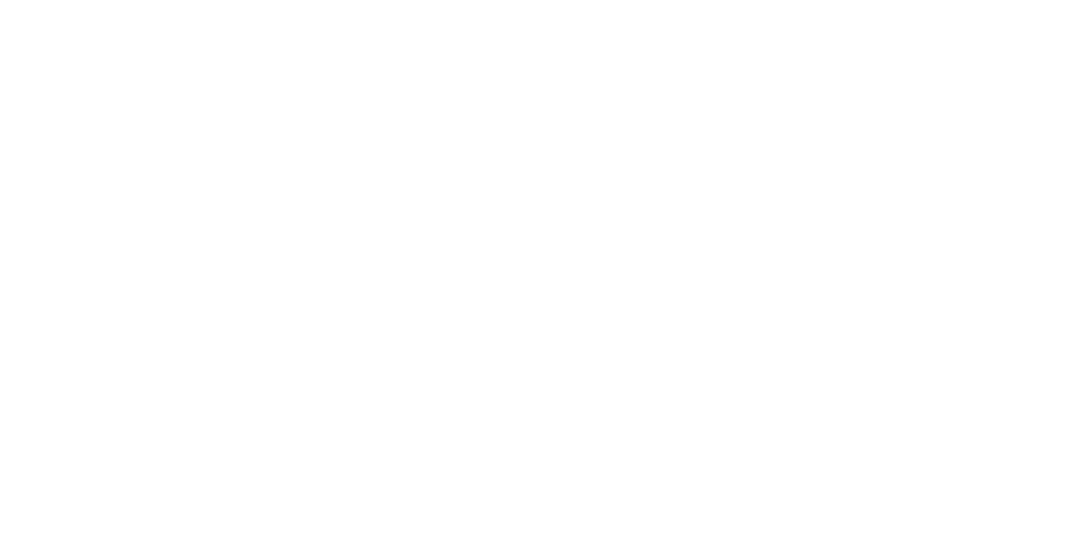

In [43]:
data=fest0['day1'].values.flatten()
data.sort()
norm=np.random.normal(0,3,len(data))
norm.sort()
plt.figure(figsize=(8,4),facecolor='1.0') 

plt.plot(norm,data,"o")

#generate a trend line as in http://widu.tumblr.com/post/43624347354/matplotlib-trendline
z = np.polyfit(norm,data, 1)
p = np.poly1d(z)
plt.plot(norm,p(norm),"k-", linewidth=2)
plt.title("Normal Q-Q plot", size=12)
plt.xlabel("Theoretical quantiles", size=10)
plt.ylabel("Expreimental quantiles", size=10)
plt.tick_params(labelsize=10)
plt.show()

<IPython.core.display.Javascript object>


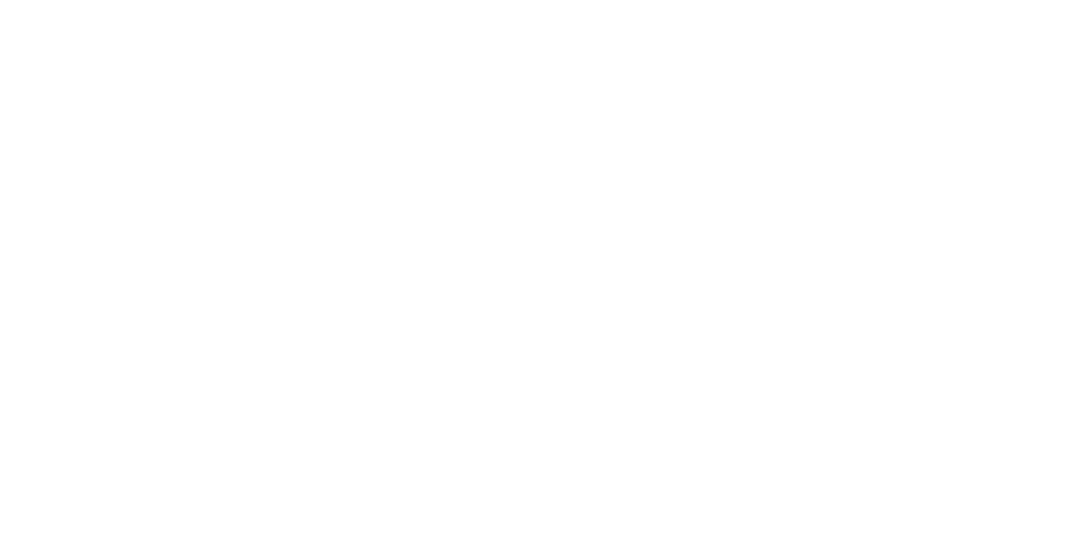

In [44]:
data= pd.to_numeric(fest0['day2'], errors='coerce').values.flatten()
data.sort()
norm=np.random.normal(0,3,len(data))
norm.sort()
plt.figure(figsize=(8,4),facecolor='1.0') 

plt.plot(norm,data,"o")

#generate a trend line as in http://widu.tumblr.com/post/43624347354/matplotlib-trendline
z = np.polyfit(norm,data, 1)
p = np.poly1d(z)
plt.plot(norm,p(norm),"k-", linewidth=2)
plt.title("Normal Q-Q plot", size=12)
plt.xlabel("Theoretical quantiles", size=10)
plt.ylabel("Experimental quantiles", size=10)
plt.tick_params(labelsize=10)
plt.show()

In [45]:
dt = fest['day1']

params = DIST.fit(dt)

arg = params[:-2]
loc = params[-2]
scale = params[-1]

params = {'loc':loc, 'scale':scale}
hist, pdf, width = plot_distribution(dt, DIST, params, bins=40)

bar = alt.Chart(hist).mark_bar().encode(
    alt.X('x:Q', bin=alt.BinParams(maxbins=50)),
    alt.Y('y:Q')
).properties(title='Day1 Hygiene', width=350)
dist = alt.Chart(pdf).mark_line(color='black').encode(
    alt.X('x:Q'),
    alt.Y('y:Q')
)
bar+dist



alt.LayerChart(...)

<IPython.core.display.Javascript object>


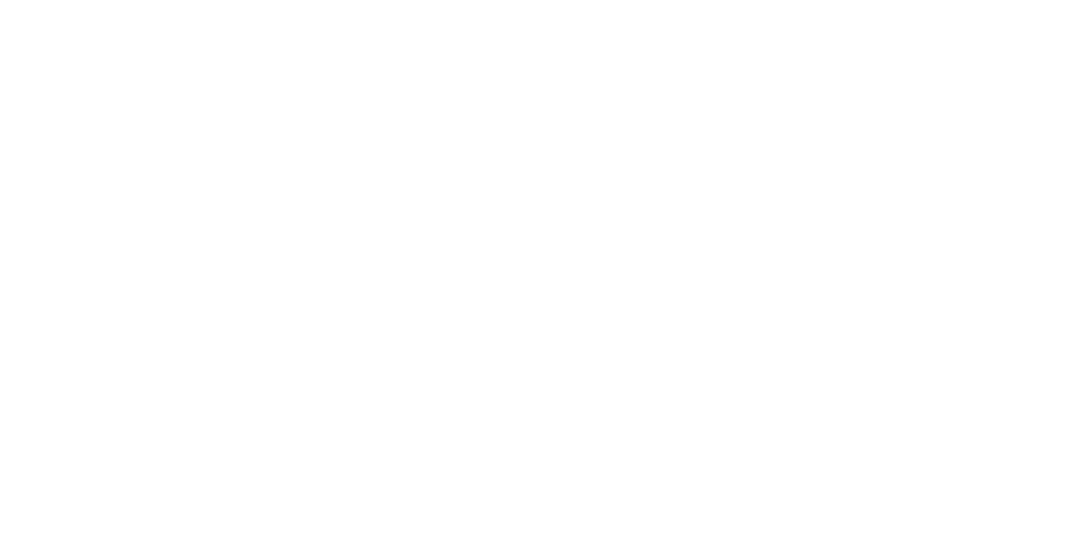

In [46]:

fig, axx = plt.subplots(figsize=(8,4), ncols=2, nrows=1, facecolor='1.0')

sm.qqplot(fest0['day1'],ax=axx[1])

ax = mp_subplot_hist(axx[0], fest0['day1'], bins=30, width=0.7, ticksize=10, title='Normal Q-Q plot day1'
                    ,xlabel='Theoretical quantiles', ylabel='Experimental quantiles')

plt.show()

In [47]:
dd=pd.read_csv('../Ott/DownloadFestival.csv')
dd['day2'] = pd.to_numeric(dd['day2'], errors='coerce')
dd['day3'] = pd.to_numeric(dd['day3'], errors='coerce')
s = DFSummary(dd)
ss = s.summary(exclude=['O'])
s['day2']

mean                            0.960909
std                              0.72078
variance                        0.519524
min                                    0
max                                 3.44
5%                                  0.14
25%                                 0.41
50%                                 0.79
75%                                 1.35
95%                                 2.44
iqr                                 0.94
kurtosis                        0.822206
skewness                         1.09523
sum                               253.68
mad                             0.562472
cv                              0.750102
zeros_num                              1
zeros_perc                         0.12%
deviating_of_mean                    549
deviating_of_mean_perc            67.78%
deviating_of_median                  559
deviating_of_median_perc          69.01%
top_correlations            day3: 66.89%
counts                               264
uniques         

In [48]:
iris = pd.read_csv('../vega_data/iris.csv')
boxplot(iris, "petal_length", "species").properties(title='Iris', width=400)

alt.LayerChart(...)

In [49]:
boxp = boxplot_altair(iris, 'species', 'petal_length', width=400)
boxp

alt.LayerChart(...)

In [50]:
from autocorrelation import autocorrelation
np.random.seed(0)
data = pd.DataFrame(dict(x=np.random.uniform(size=100)))
autocorrelation(data, "x", max_lag=15)

alt.Chart(...)

In [51]:
from qqplot import qqplot
df = pd.DataFrame({
        'Trial A': np.random.normal(0, 0.8, 1000),
        'Trial B': np.random.normal(-2, 1, 1000),
        'Trial C': np.random.uniform(3, 2, 1000)
})
qqplot(df, x='Trial A', y='Trial C')

alt.Chart(...)

<IPython.core.display.Javascript object>


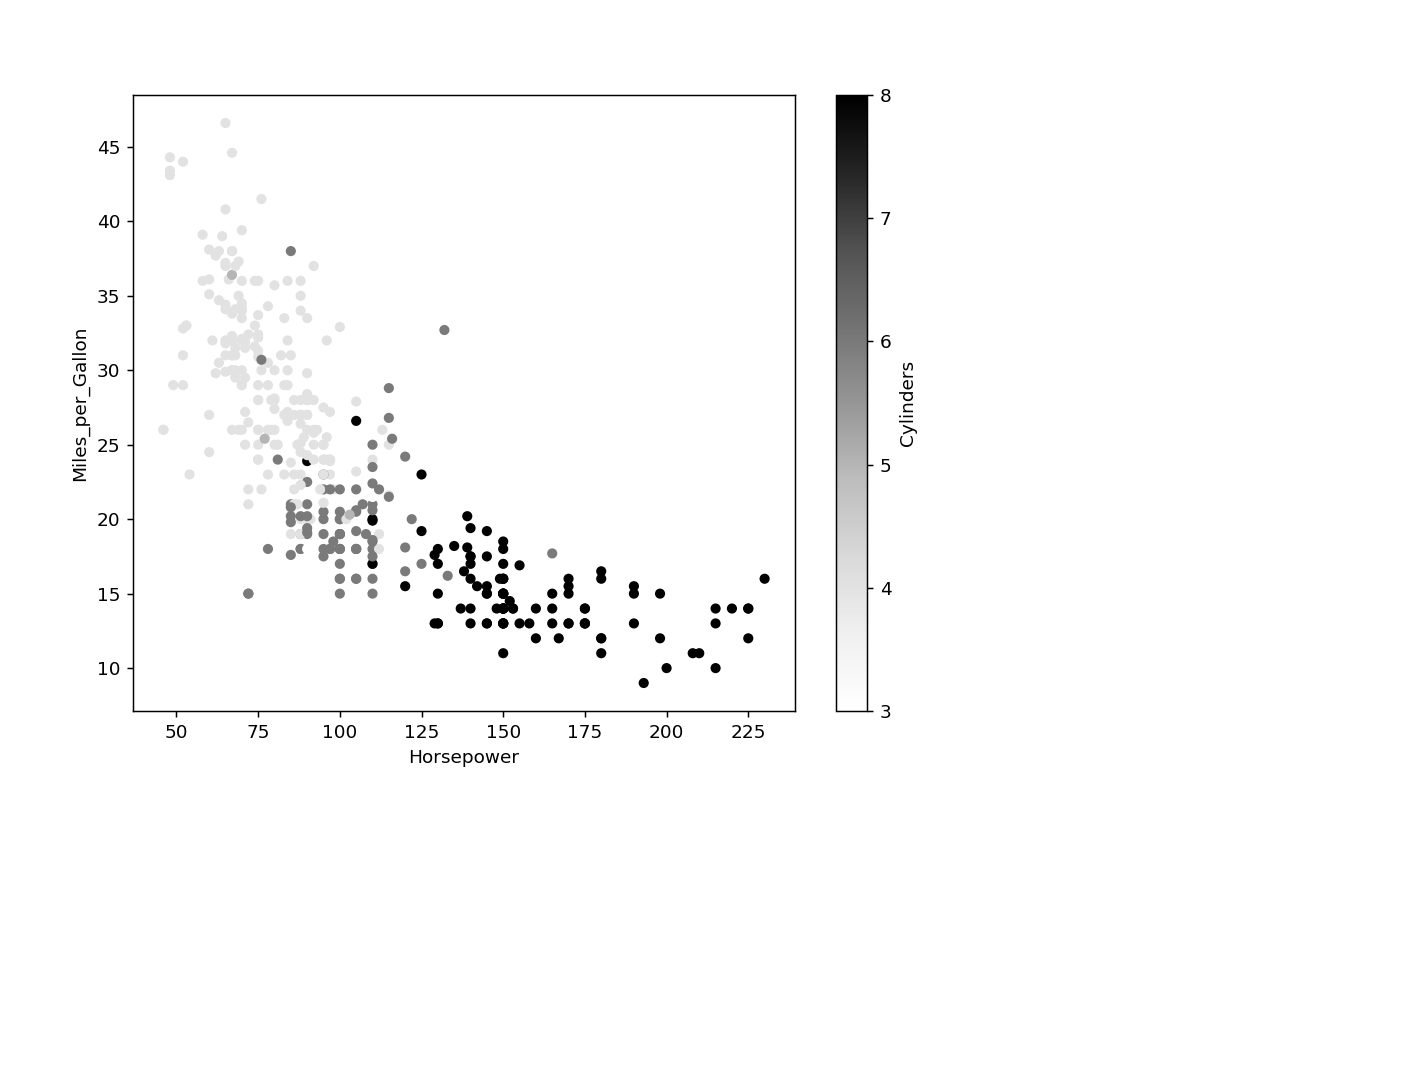

In [4]:
cars = vegdat('cars')
cars.head()
cars.plot.scatter(x='Horsepower', y='Miles_per_Gallon', c='Cylinders', figsize=(8,6))

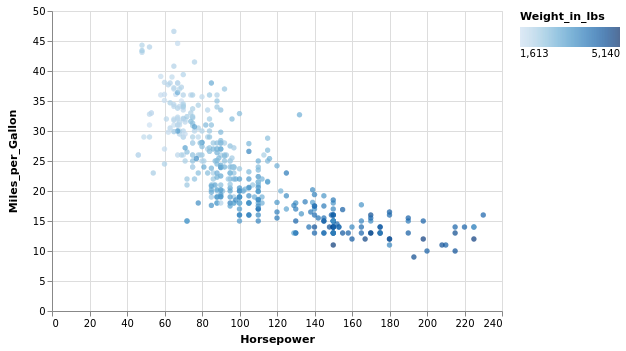

In [5]:
cars.vgplot.scatter(x='Horsepower', y='Miles_per_Gallon', c='Weight_in_lbs')


<IPython.core.display.Javascript object>


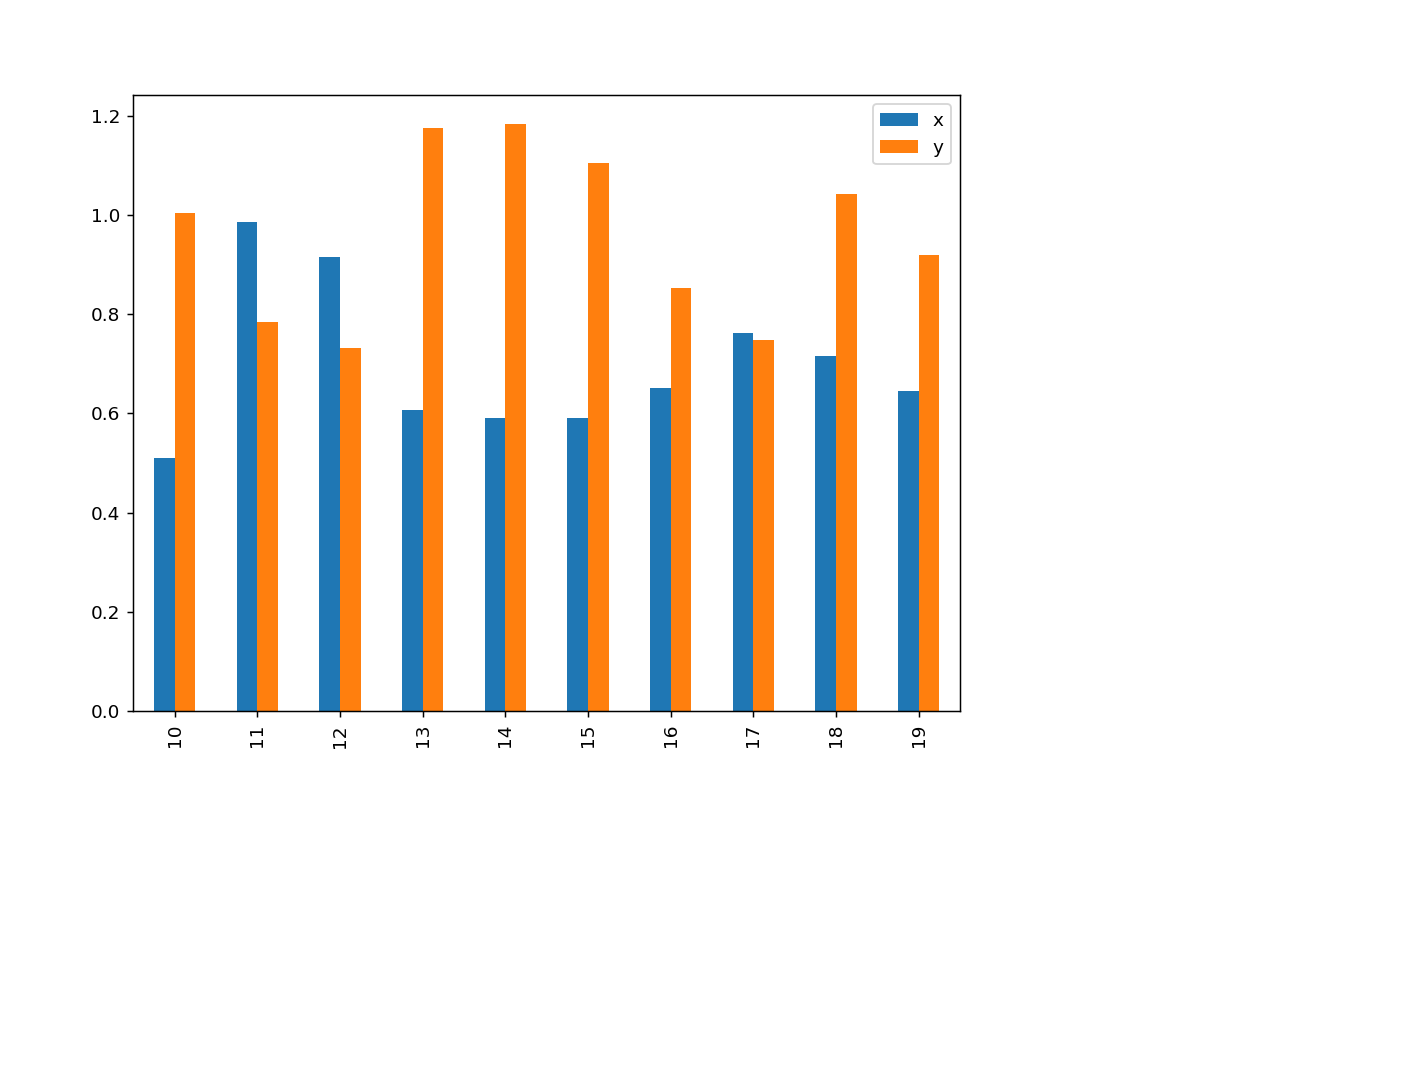

In [6]:
rand = np.random.RandomState(42)
df = pd.DataFrame({'x': 0.5 + 0.5 * rand.rand(20),
                   'y': 0.7 + 0.5 * rand.rand(20)})
df.iloc[-10:].plot.bar(figsize=(8,6))

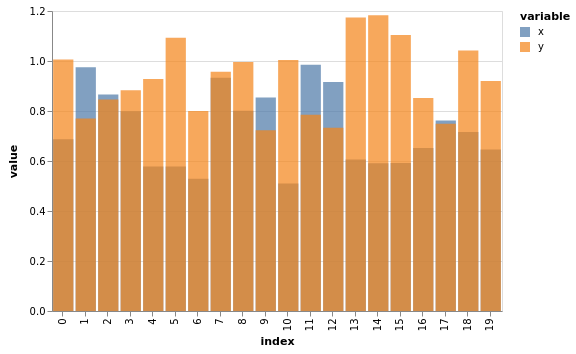

In [7]:
df.vgplot.bar()

<IPython.core.display.Javascript object>


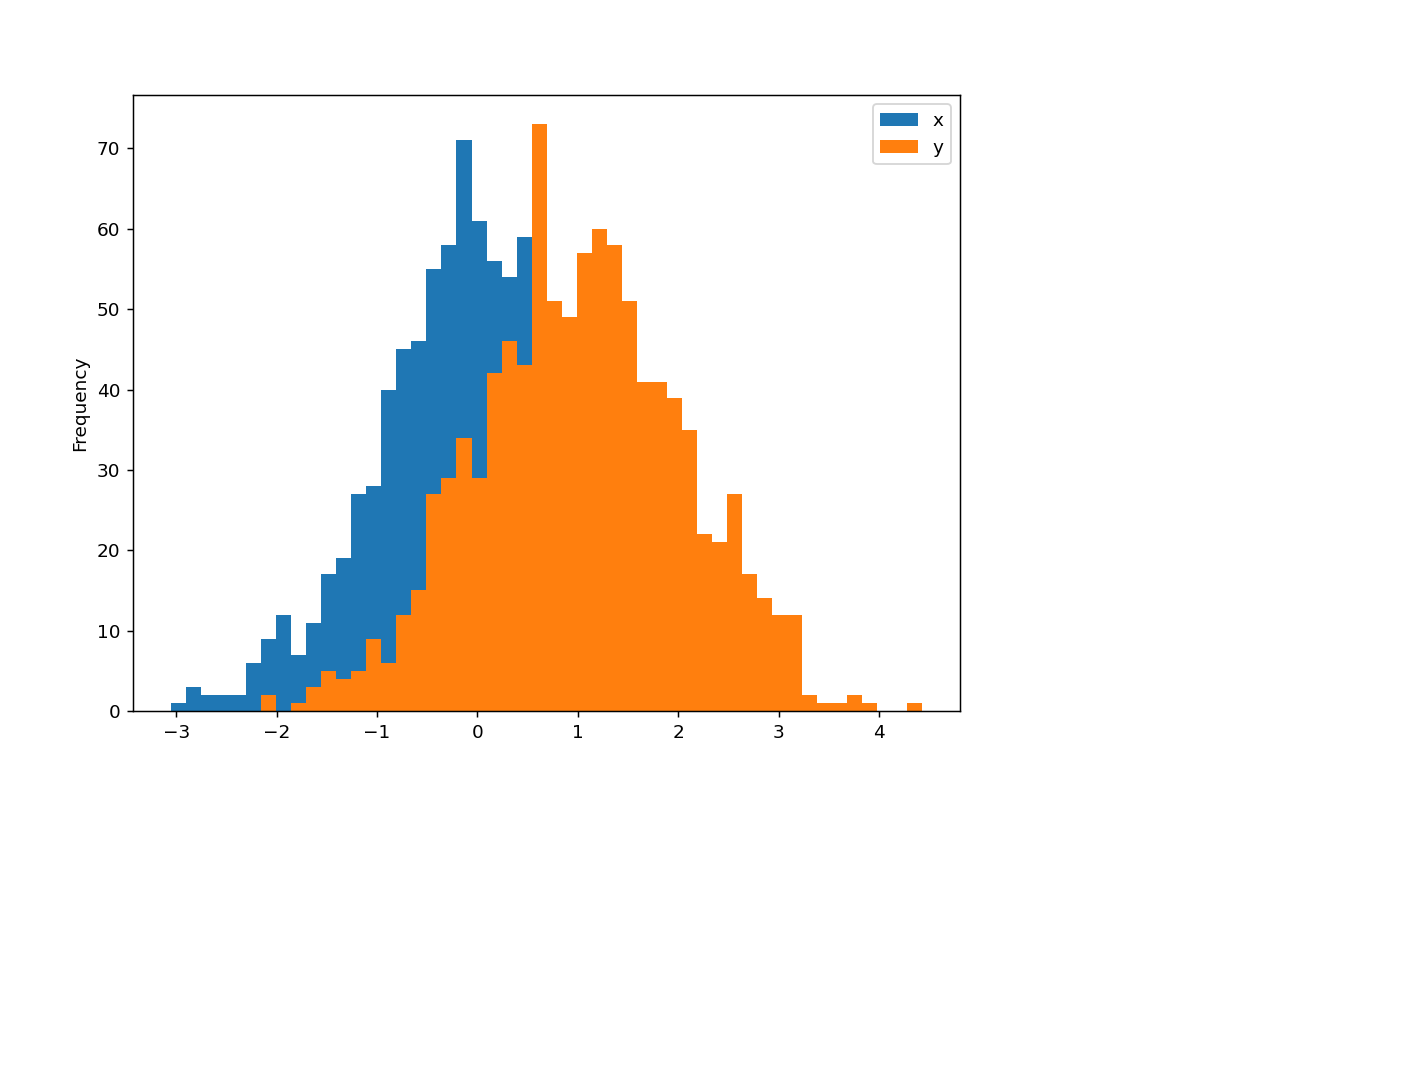

,x,y
0,1.624345,0.846764
1,-0.611756,-1.432509
2,-0.528172,1.507984
3,-1.072969,0.675968
4,0.865408,-0.511077


In [8]:
df = pd.DataFrame({'x': np.random.randn(1000),
                   'y': 1 + np.random.randn(1000)})
df.plot.hist(bins=50, figsize=(8,6))
df.head()

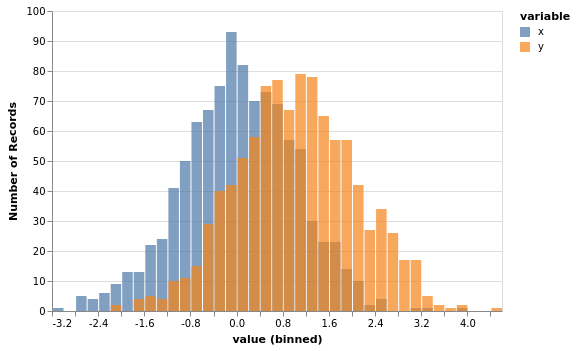

In [9]:
df.vgplot.hist(bins=50)

/usr/local/lib/python3.7/site-packages/pdvega/plotting.py:47: UserWarning: Unrecognized keywords in pdvega.scatter_matrix: ['skipna']
  "".format(list(kwds.keys())))


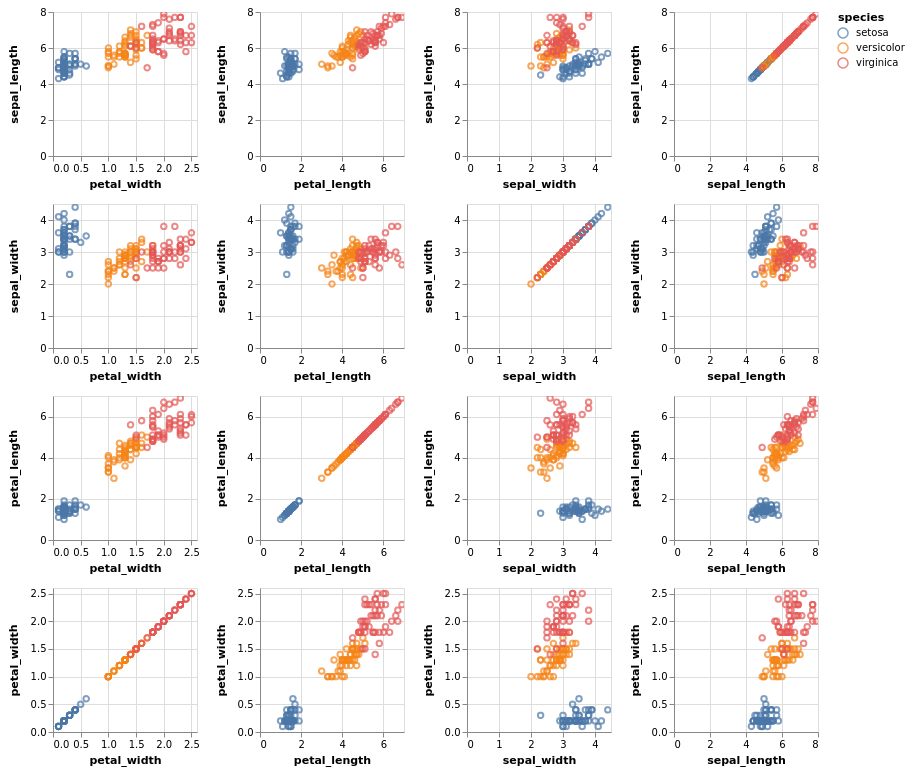

In [10]:
pdvega.plotting.scatter_matrix(iris, 'species', figsize=(10, 10), skipna=True)


<IPython.core.display.Javascript object>


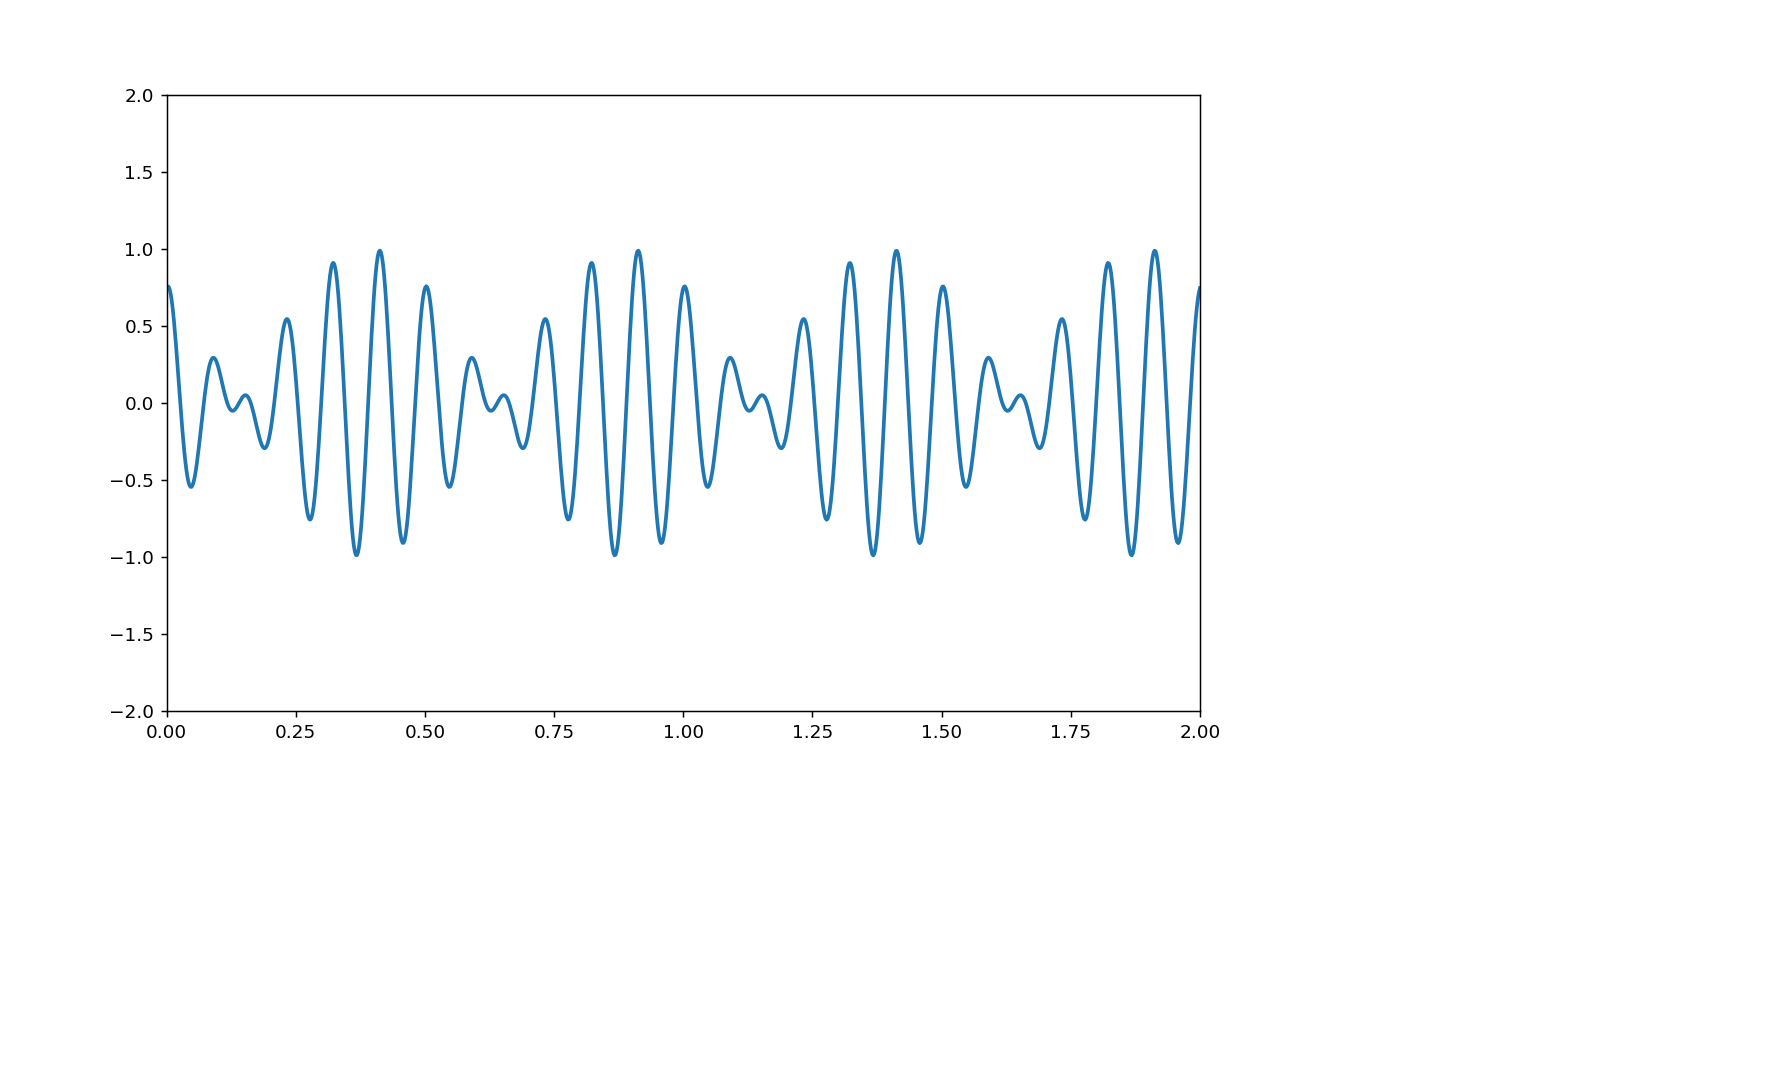

In [11]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 2), ylim=(-2, 2))
line, = ax.plot([], [], lw=2)
def init():
    """Clears current frame."""
    line.set_data([], [])
    return line

def animate(i):
    """Draw figure.
       @param i: Frame counter
       @type i: int
    """
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i)) * np.cos(22 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line

animator = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=200, interval=20, blit=True)

In [12]:
#print(R.packdesc('base'))
passs =  R.data_from('base','BOD')
passs = R.R2pd(passs)
passs

,BOD.Time,BOD.demand
1,1.0,8.3
2,2.0,10.3
3,3.0,19.0
4,4.0,16.0
5,5.0,15.6
6,7.0,19.8


In [13]:
stocks = vegdat.stocks(pivoted=True)
stocks.head()

symbol,AAPL,AMZN,GOOG,IBM,MSFT
date,,,,,
2000-01-01,25.94,64.56,NaN,100.52,39.81
2000-02-01,28.66,68.87,NaN,92.11,36.35
2000-03-01,33.95,67.00,NaN,106.11,43.22
2000-04-01,31.01,55.19,NaN,99.95,28.37
2000-05-01,21.00,48.31,NaN,96.31,25.45


<IPython.core.display.Javascript object>


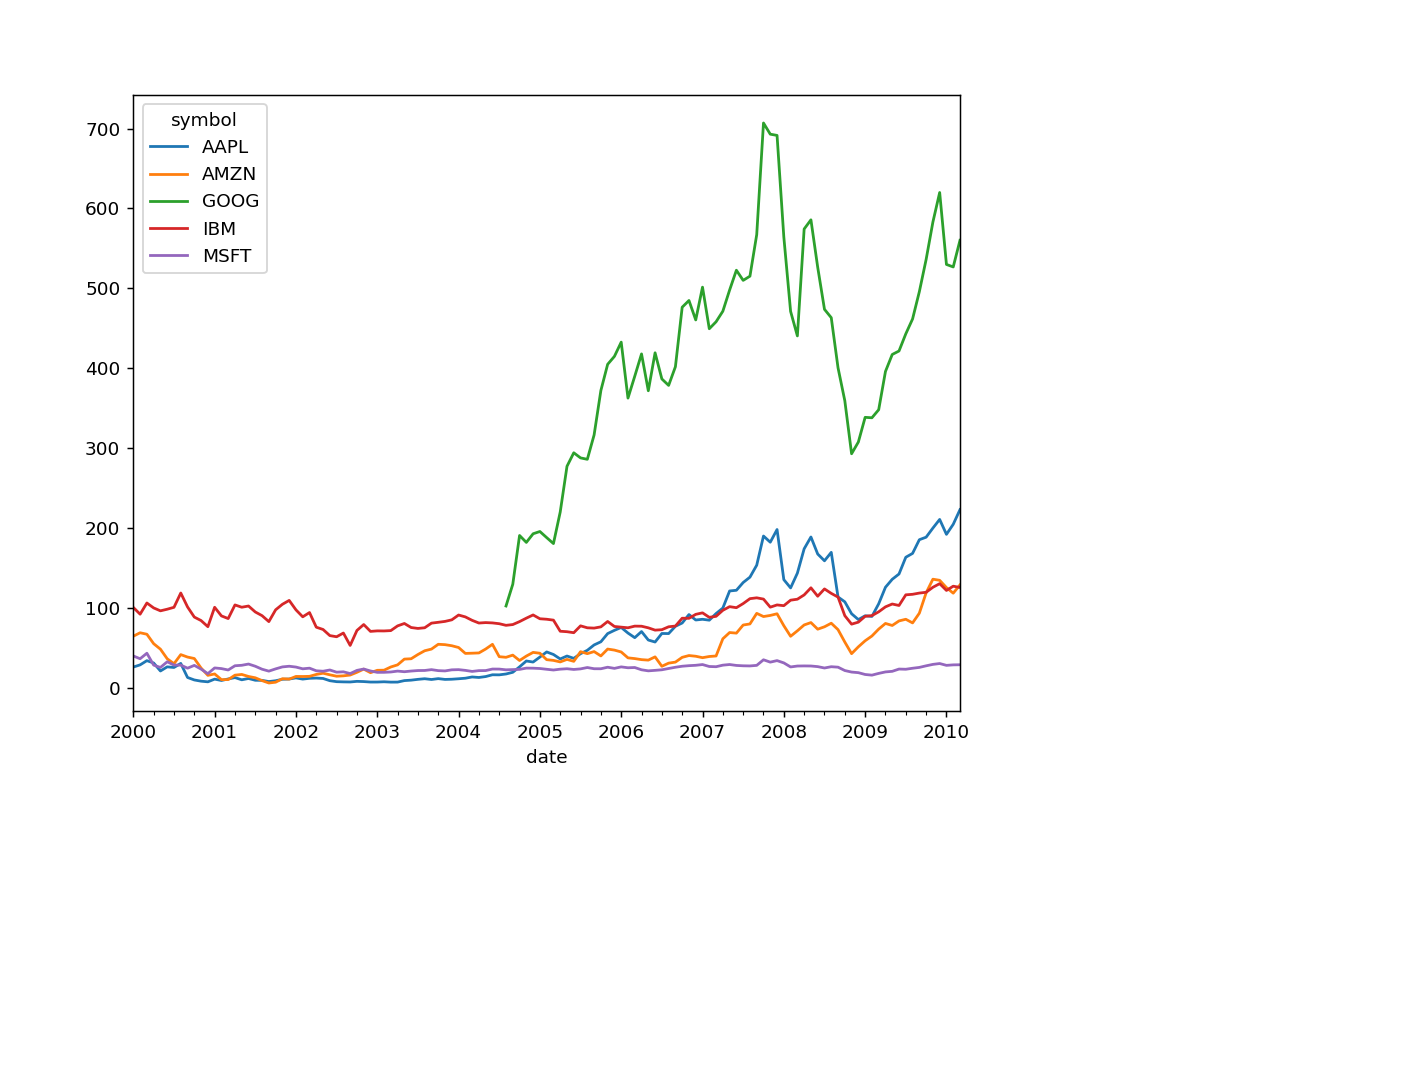

In [14]:
stocks.plot(figsize=(8,6))